# Quantum-classical Mapping

## Code for simulating and infering the classical dynamics

We want to simulate the dynamics

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s}+\sum_{K=1,2,\dots k} \sum_{a_k} g_{a_k}(s) \delta_{s^{\prime}, F_{a_k}[s]}$

The dirac deltas are there only to tell you which of the states is actually selected, all the calculation is in the flip-probabilities $g_a = [{g_i, g_{ij}}]$. The indices refer to which spin will get flipped. Your data would have the form of $(s_0,s_1, \dots s_t)$ with $s_i$  being states of the system. The $a$ represents a n-spin flip.  $g_i$ is the probability of the flip occurring.

This expression tells us that the transition probability is the sum of all probabilities of all the ways to get into state $s'$ using up to $a$-spin flips. We can use it to calculate the transition rates from a time series. w is an extra parameter that encodes the time scales of the transitions. Not related to coupling between spins.

For fully connected systems we have the flipping parameters:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{k} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{k'} J_{jk'} s_{k'} + h_j \right] \right)$

Formalism -1/1 -> 0/1 for binary representation

We set $\beta = 1$ throughout the code

In [359]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import minimize

In [381]:
###  AUXILARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx, N):
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # Get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # Convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s):
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # Convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # Set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx, flip_index, N):
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

@njit
def choice(probabilities):
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

def unpack_params(params, n_spins):
    w_flat = params[:n_spins**2]
    h = params[n_spins**2:n_spins**2 + n_spins]
    J_flat = params[n_spins**2 + n_spins: -1]
    no_flip_prob = params[-1]
    
    w = w_flat.reshape((n_spins, n_spins))
    J = J_flat.reshape((n_spins, n_spins))
    
    return w, h, J, no_flip_prob

def pack_params(w, h, J, no_flip_prob):
    w_flat = w.flatten()
    J_flat = J.flatten()
    no_flip_prob_array = np.array([no_flip_prob])
    
    return np.concatenate([w_flat, h, J_flat, no_flip_prob_array])

In [395]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i]
    for j in range(len(s)):
        if i != j:
            sum_term += J[i, j] * s[j]
    return np.exp(-w[i, i] - s[i] * sum_term)


@njit
def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i]
    for k in range(len(s)):
        if k != i:
            sum_term_i += J[i, k] * s[k]

    sum_term_j = h[j]
    for k in range(len(s)):
        if k != j:
            sum_term_j += J[j, k] * s[k]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)

@njit
def spin_flip_parallel(s, w, h, J, no_flip_prob, transition_matrix):
    """
    Flipping algorithm using parallel dynamics using double-spin flips.
    Calculates and stores W when needed.
    """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # update the corresponding row in the transition matrix if it's not yet filled
    if not np.any(transition_matrix[s_idx]):

        # calculate all possible flipping probabilities from state s
        flip_probs = np.zeros((2**N))  # Initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

        # normalize the probabilities and add the no-flip probability
        flip_probs_sum = sum(flip_probs)
        flip_probs = np.array([(1 - no_flip_prob) * prob / flip_probs_sum for prob in flip_probs])
        flip_probs[s_idx] = no_flip_prob

        transition_matrix[s_idx] = flip_probs
    else:
        flip_probs = transition_matrix[s_idx]   # get probabilities

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    if idx == s_idx:  # no flip
        pass

    elif idx in [s_idx ^ (1 << i) for i in range(N)]:  # single flip
        i = bits_flipped_indices(s_idx, idx, N)[0]
        s[i] *= -1

    else:  # double flip
        i,j = bits_flipped_indices(s_idx, idx, N)
        s[i] *= -1
        s[j] *= -1

    return s, transition_matrix

@njit
def simulate_and_infer_dynamics(w, J, h, steps, n_spins, no_flip_prob, fill_missing_entries=True):
    
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(n_spins)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, n_spins), dtype=np.int64)
    # Initialize the transition matrix
    transition_matrix = np.zeros((2**n_spins, 2**n_spins))

    for t in range(steps):
        s, transition_matrix = spin_flip_parallel(s, w, h, J, no_flip_prob, transition_matrix)
        trajectory[t] = s

    # If fill_missing_entries is True, fill in the missing rows in the transition matrix after the simulation
    if fill_missing_entries:
        fill_missing_transition_rows(transition_matrix, w, h, J, no_flip_prob)

    return trajectory, transition_matrix

# @njit
def simulate_dynamics(W, steps, n_spins):
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(n_spins)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, n_spins), dtype=np.int64)

    for t in range(steps):
        s_idx = spin_state_to_index(s)
        flip_probs = W[s_idx]
        idx = choice(flip_probs)

        if idx == s_idx:  # no flip
            pass
        elif idx in [s_idx ^ (1 << i) for i in range(n_spins)]:  # single flip
            i = bits_flipped_indices(s_idx, idx, n_spins)[0]
            s[i] *= -1
        else:  # double flip
            i, j = bits_flipped_indices(s_idx, idx, n_spins)
            s[i] *= -1
            s[j] *= -1

        trajectory[t] = s

    return trajectory


@njit
def fill_missing_transition_rows(transition_matrix, w, h, J, no_flip_prob):
    """Fill in the missing rows in the transition matrix after the simulation"""
    n_spins = int(np.log2(transition_matrix.shape[0]))
    for s_idx in range(transition_matrix.shape[0]):
        if np.any(transition_matrix[s_idx]):
            continue
        # Convert the index to a spin state
        s = index_to_spin_state(s_idx, n_spins)
        spin_flip_parallel(s, w, h, J, no_flip_prob, transition_matrix)

In [396]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------

def plot_combined_dynamics(trajectory, n_spins):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(n_spins):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()


In [397]:
###  INFERENCE FUNCTIONS
#----------------------------------------------------------------------
@njit
def infer_transition_matrix(trajectory):
    """Infers the transition matrix from a time series of the states of the system"""
    n_spins = trajectory.shape[1]
    n_states = 2**n_spins

    # initialize the transition matrix
    transition_matrix = np.zeros((n_states, n_states))

    # count the transitions from each state to each other state
    for i in range(len(trajectory) - 1):
        # Convert the spin states to indices
        from_idx = spin_state_to_index(trajectory[i])
        to_idx = spin_state_to_index(trajectory[i+1])

        # Update the transition matrix
        transition_matrix[from_idx, to_idx] += 1

    # Normalize each row of the transition matrix
    for i in range(n_states):
        row_sum = transition_matrix[i].sum()
        if row_sum > 0:
            transition_matrix[i] /= row_sum

    return transition_matrix


def likelihood(params, W, n_spins):
    w, h, J, no_flip_prob = unpack_params(params, n_spins)

    epsilon = 1e-12                           
    no_flip_prob = max(epsilon, no_flip_prob)  # ensure no_flip_prob is not zero
    
    _, W_hat = simulate_and_infer_dynamics(w, J, h, steps=1000, n_spins=n_spins, no_flip_prob = no_flip_prob, fill_missing_entries=True)
    
    likelihood = np.sum(W * np.log(W_hat + 1e-12))
    
    return -likelihood  # return the negative likelihood to minimize


def optimize_parameters(W_obs, n_spins, seed=None, n_init=100):
    best_likelihood = float('inf')
    best_params = None

    for _ in range(n_init):
        # set random seed
        if seed is not None:
            np.random.seed(seed)

        # initialize random parameters and no_flip in middle
        w_init = np.random.randn(n_spins, n_spins)
        h_init = np.random.randn(n_spins)
        J_init = np.random.randn(n_spins, n_spins)
        no_flip_prob = 0.5

        params_init = pack_params(w_init, h_init, J_init, no_flip_prob)

        # perform the optimization
        result = minimize(likelihood, params_init, args=(W_obs, n_spins), method="BFGS")

        # check if the current run has a better likelihood
        if result.fun < best_likelihood:
            best_likelihood = result.fun
            best_params = result.x

    # unpack the optimized parameters from the best run
    w_opt, h_opt, J_opt, no_flip_prob = unpack_params(best_params, n_spins)

    return w_opt, h_opt, J_opt, no_flip_prob


In [398]:
###  2-QUBIT QBM FUNCTIONS
#----------------------------------------------------------------------

@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res

def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex64)

    interactions = np.zeros((4, 4, 4, 4), dtype=np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k, kprime] = np.kron(pau[k], pau[kprime])
    return interactions

@njit
def hamiltonian2spins(J,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    H = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            H += J[k,kprime] * interactions[k,kprime]
    return H

@njit
def rho_model(w,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H      = hamiltonian2spins(w,interactions)        #  get hamiltonian matrix
    rho    = expmat(H)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

@njit
def observables(rho, interactions):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros((4,4))
    for k in range(4):
        for kprime in range(4):
            obs[k,kprime] = np.real(np.trace(rho@interactions[k,kprime]))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def generate_random_parameter_matrix(seed):
    np.random.seed(seed)              # set random seed for reproducibility
    w = np.random.randn(4, 4)         # get normal distributed weights
    w[0, 0] = 0
    return w

def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

@njit
def learn_w(w_eta, interactions, lr, maxiter, tol, random_seed):
    """
    Train the model to fit the target distribution eta
    """
    eta  = rho_model(w_eta, interactions)                  # compute density matrix using ED
    obs_clamped  = observables(eta, interactions)          # get QM clamped statistics  
    
    w    = generate_random_parameter_matrix(random_seed)  # initialize random parameters
    rho  = rho_model(w, interactions)                      # compute density matrix using ED
    obs  = observables(rho, interactions)                  # get QM statistics  
    
    it = 0                                                 #  initialize gradient ascent loop
    diff = np.max(np.abs(obs-obs_clamped))
    Wmax_list = np.zeros(maxiter)                          #  initialize values to store
    KL_list   = np.zeros(maxiter)
    
    
    while (diff > tol and it < maxiter): 
        rho  = rho_model(w, interactions)                   # compute density matrix using ED
        obs  = observables(rho, interactions)               # get QM statistics  
        w              += lr * (obs_clamped -  obs)         #  update parameters
        
        diff = np.max(np.abs(obs - obs_clamped))            #  evaluate differences in clamped and model statistics        
        Wmax = np.max(np.abs(w-w_eta))
        
        Wmax_list[it] = Wmax                                #  store values
        KL_list[it]   = KL_divergence(eta,rho) 
        it += 1 
    return w, rho, KL_list, Wmax_list, it

In [399]:
### QBM <-> DYNAMICS FUNCTIONS
#----------------------------------------------------------------------
# @njit
def transition_matrix_to_density_matrix(W):
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W)
    p = np.abs(eigenvectors[:, eigenvalues.argmax()])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / p)
    A = inv_sqrt_p_diag @ W @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # normalize
    rho = A / np.trace(A)
    return rho, p

# @njit
def density_matrix_to_transition_matrix(rho):
    # calculate steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eig(rho)
    sqrt_p = np.abs(eigenvectors[:, eigenvalues.argmax()])
    sqrt_p = sqrt_p / np.sum(sqrt_p)    #normalize steady-state distribution

    sqrt_p_diag = np.diag(sqrt_p)
    inv_sqrt_p_diag = np.diag(1 / sqrt_p)

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = inv_sqrt_p_diag @ A @ sqrt_p_diag

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1, keepdims=True)
    W /= W_row_sum
    
    return W, sqrt_p

def check_ergodicity(rho, K=10):
    """
    Check if the density matrix rho is ergodic by iteratively squaring
    the matrix up to K times and checking for non-zero entries.
    """
    for _ in range(K):
        if np.all(rho > 0):
            return True
        
        # quadratic of the density matrix
        rho = rho @ rho

    # if after K iterations, there are still zero components, the matrix is not ergodic.
    return False

def check_single_flip_ergodicity(rho, W, n_spins):
    """
    Check if the components of the density matrix rho that correspond to 
    the transitions of the transition matrix W involving single spin flips are non-zero.
    """
    n_states = 2 ** n_spins

    for from_idx in range(n_states):
        for i in range(n_spins):
            # calculate the index of the state with the ith spin flipped
            to_idx = from_idx ^ (1 << i)

            # if the transition corresponds to a single spin flip and the component in rho is zero, return False
            if W[from_idx, to_idx] > 0 and rho[from_idx, to_idx] == 0:
                return False

    # if all components corresponding to single spin flips are non-zero, return True
    return True

## Example forward simulation for N =3

Maximum difference between W_model and W_empirical: 0.79


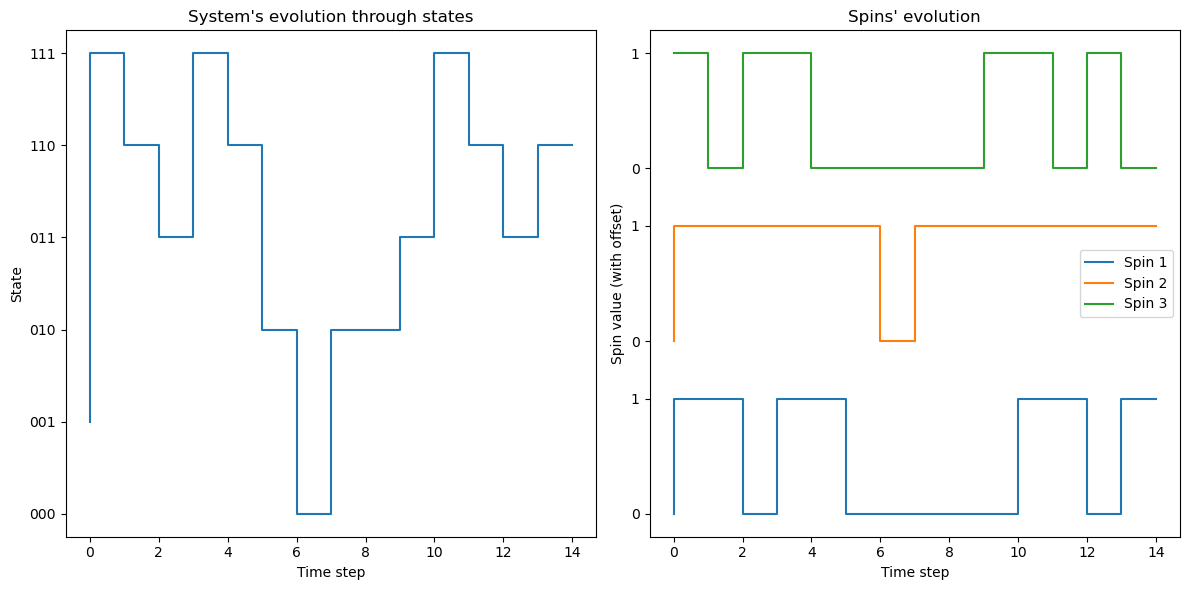

In [400]:
n_spins = 3
w = np.array([[1,1,1],
              [1,1,1],
              [1,2,1]])
J = np.array([[1,1,4],
              [2,1,1],
              [1,1,3]])
h = np.array([0, 3, 0])

steps = 15
no_flip_prob = 0.1

# SIMULATE SYSTEM
trajectory, W_model = simulate_and_infer_dynamics(w, J, h, steps, n_spins, no_flip_prob, fill_missing_entries=True)
W_empirical = infer_transition_matrix(trajectory)

# SET PRINT OPTIONS
np.set_printoptions(precision=2, suppress=True)

# PRINT RESULTS
print(f"Maximum difference between W_model and W_empirical: {np.max(W_model - W_empirical):.2f}")

plot_combined_dynamics(trajectory, n_spins)

## Inverse parameter mapping for N = 2

Input QM parameters: 
 [[0 1 0 1]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]
Optimized w: 
 [[-1.2   1.32]
 [-0.98 -1.2 ]]
Optimized h: 
 [-1.62 -1.62]
Optimized J: 
 [[-1.2  -0.75]
 [-0.75  0.01]]
No flip prob 0.2804267289067183


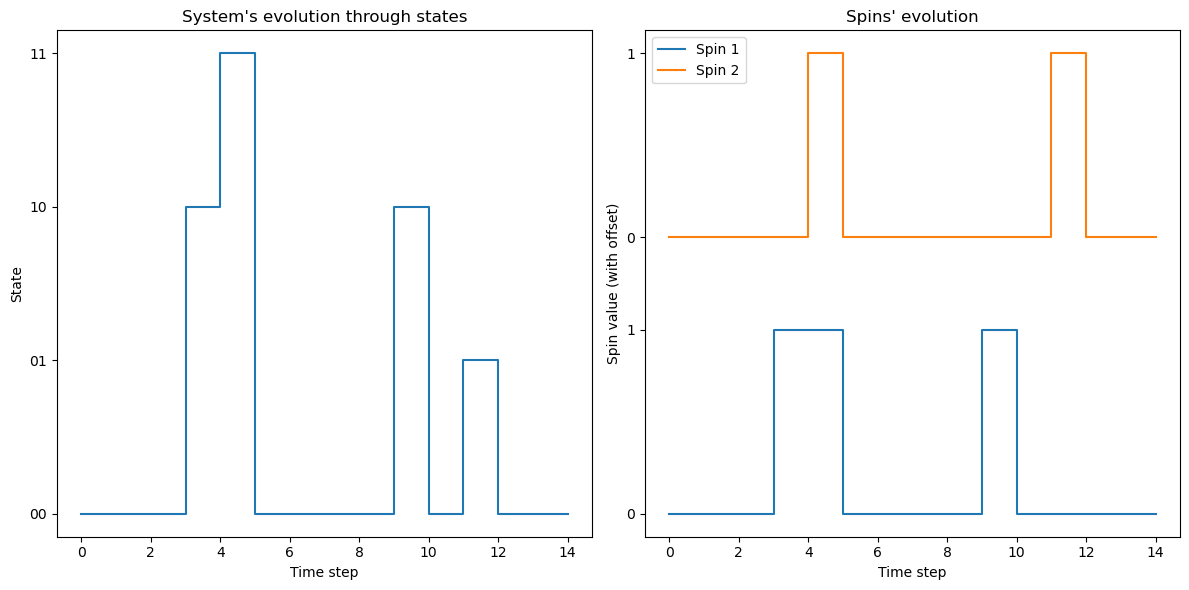

In [401]:
# QM HAMILTONIAN PARAMETERS
wx1x2 = 0
wy1y2 = 0
wz1z2 = 0
hx1   = 1
hx2   = 1
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w_eta            = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)   

# QBM PARAMETERS
lr       = 1.2      #  learning rate 
maxiter  = 2**16    #  iterations
tol      = 1e-10    #  tolerance
random_seed = 666

# DYNAMICS PARAMETERS
n_spins = 2
steps = 15

#QUANTUM HAMILTONIAN TO RHO
interactions     = generate_interaction_matrices()     
_, rho, _, _, _ = learn_w(w_eta, interactions, lr, maxiter, tol, random_seed)

#RHO TO W
W, _ = density_matrix_to_transition_matrix(rho)
if not check_ergodicity(rho, K=10):
    print('error')

# SIMULATE SYSTEM & INFER PARAMETERS
trajectory = simulate_dynamics(W, steps, n_spins)
w_opt, h_opt, J_opt, no_flip_prob = optimize_parameters(W, n_spins, seed=None)

print(f"Input QM parameters: \n {w_eta}")
print(f"Optimized w: \n {w_opt}")
print(f"Optimized h: \n {h_opt}")
print(f"Optimized J: \n {J_opt}")
print(f"No flip prob {no_flip_prob}")

plot_combined_dynamics(trajectory, n_spins)

## Attempt at PPT slide recreation

Like you did for the first slide, I defined the QM hamiltonian using only 

Input QM parameters: 
 [[0 1 0 0]
 [1 2 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Optimized w: 
 [[ 0.52 -0.75]
 [ 0.49  0.52]]
Optimized h: 
 [0. 0.]
Optimized J: 
 [[ 1.34 -1.5 ]
 [-1.5  -1.51]]
No flip prob 0.25581828339785917


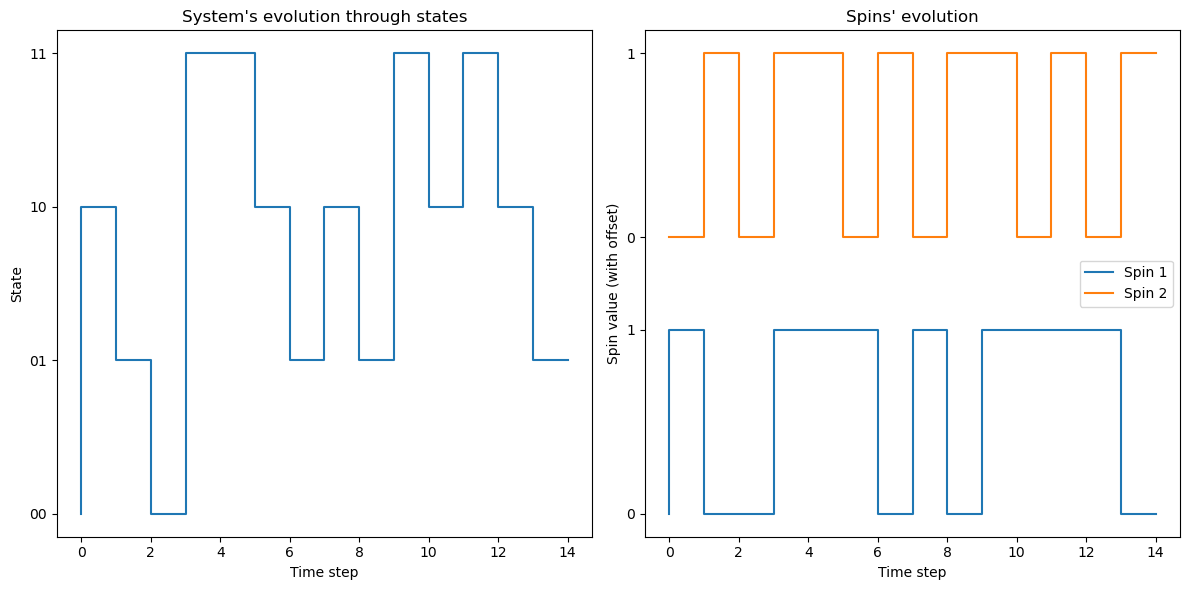

In [415]:
# QM HAMILTONIAN PARAMETERS
wx1x2 = 2
wy1y2 = 0
wz1z2 = 0
hx1   = 1
hx2   = 1
hy1   = 0
hy2   = 0
hz1   = 0
hz2   = 0

w_eta            = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)   

#QUANTUM HAMILTONIAN TO RHO
interactions     = generate_interaction_matrices()     
_, rho, _, _, _ = learn_w(w_eta, interactions, lr, maxiter, tol, random_seed)

#RHO TO W
W, _ = density_matrix_to_transition_matrix(rho)
if not check_ergodicity(rho, K=10):
    print('error')

# SIMULATE SYSTEM & INFER PARAMETERS
trajectory = simulate_dynamics(W, steps, n_spins)
w_opt, h_opt, J_opt, no_flip_prob = optimize_parameters(W, n_spins, seed=None, n_init=1000)

print(f"Input QM parameters: \n {w_eta}")
print(f"Optimized w: \n {w_opt}")
print(f"Optimized h: \n {h_opt}")
print(f"Optimized J: \n {J_opt}")
print(f"No flip prob {no_flip_prob}")

plot_combined_dynamics(trajectory, n_spins)